In [41]:
import pandas as pd
import os

In [42]:
# load raw data

df_dict = {}

for file in os.listdir('data/raw'):
    if file.endswith(".csv"):
        df_dict[file[:-4]] = pd.read_csv(f'data/raw/{file}')
        print(f'Loaded {file[:-4]} with {df_dict[file[:-4]].shape[0]} rows and {df_dict[file[:-4]].shape[1]} columns')

Loaded superset with 590154 rows and 10 columns
Loaded popquorn with 13036 rows and 9 columns
Loaded kumar with 538100 rows and 30 columns


In [43]:
# clean raw data

# for KUMAR, select relevant columns and rename them
df_dict["kumar"] = df_dict["kumar"][["comment_id", "comment"]]
df_dict["kumar"].rename(columns={"comment_id": "instance_id", "comment": "text"}, inplace=True)

# for POPQUORN, select relevant columns, already with correct name
df_dict["popquorn"] = df_dict["popquorn"][["instance_id", "text"]]

# for SUPERSET, create instance_id column based on index, drop rows where "perspective_score" is empty, select relevant columns
df_dict["superset"]["instance_id"] = df_dict["superset"].index
df_dict["superset"] = df_dict["superset"].dropna(subset=["perspective_score"])
df_dict["superset"] = df_dict["superset"][["instance_id", "text"]]

# deduplicate based on ID
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop_duplicates(subset="instance_id")
    print(f'Deduplicated {key} to {df_dict[key].shape[0]} rows based on ID')

# deduplicate based on text
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop_duplicates(subset="text")
    print(f'Deduplicated {key} to {df_dict[key].shape[0]} rows based on text')

# save cleaned data
for key in df_dict.keys():
    df_dict[key].to_csv(f'data/clean/{key}.csv', index=False)
    print(f'Saved {key} with {df_dict[key].shape[0]} rows and {df_dict[key].shape[1]} columns')

Deduplicated superset to 590150 rows based on ID
Deduplicated popquorn to 1500 rows based on ID
Deduplicated kumar to 104687 rows based on ID
Deduplicated superset to 346235 rows based on text
Deduplicated popquorn to 1500 rows based on text
Deduplicated kumar to 103164 rows based on text
Saved superset with 346235 rows and 2 columns
Saved popquorn with 1500 rows and 2 columns
Saved kumar with 103164 rows and 2 columns


In [44]:
# load perspective preds

preds_dict = {}

for file in os.listdir('data/perspective_preds'):
    if file.endswith('.csv'):
        preds_dict[file[:-4]] = pd.read_csv(f'data/perspective_preds/{file}')
        if "Unnamed: 0" in preds_dict[file[:-4]].columns:
            preds_dict[file[:-4]].drop(columns="Unnamed: 0", inplace=True)
        print(f'Loaded {file[:-4]} with {preds_dict[file[:-4]].shape[0]} rows and {preds_dict[file[:-4]].shape[1]} columns')

Loaded superset with 590150 rows and 7 columns
Loaded popquorn with 1500 rows and 7 columns
Loaded kumar with 105817 rows and 8 columns


In [45]:
# merge perspective preds with cleaned data

for key in preds_dict.keys():
    df_dict[key] = pd.merge(df_dict[key], preds_dict[key], on="instance_id", how="left")
    print(f'Merged {key} with {df_dict[key].shape[0]} rows and {df_dict[key].shape[1]} columns')

# make sure all columns are in the same order
for key in df_dict.keys():
    df_dict[key] = df_dict[key][["instance_id", "text", 'IDENTITY_ATTACK', 'THREAT', 'SEVERE_TOXICITY', 'INSULT', 'PROFANITY', 'TOXICITY']]
    print(f'Ordered columns for {key}')

# check for NA values
#for key in df_dict.keys():
#    print(f'NA values in {key}:')
#    print(df_dict[key].isna().sum())

Merged superset with 346235 rows and 8 columns
Merged popquorn with 1500 rows and 8 columns
Merged kumar with 104288 rows and 9 columns
Ordered columns for superset
Ordered columns for popquorn
Ordered columns for kumar


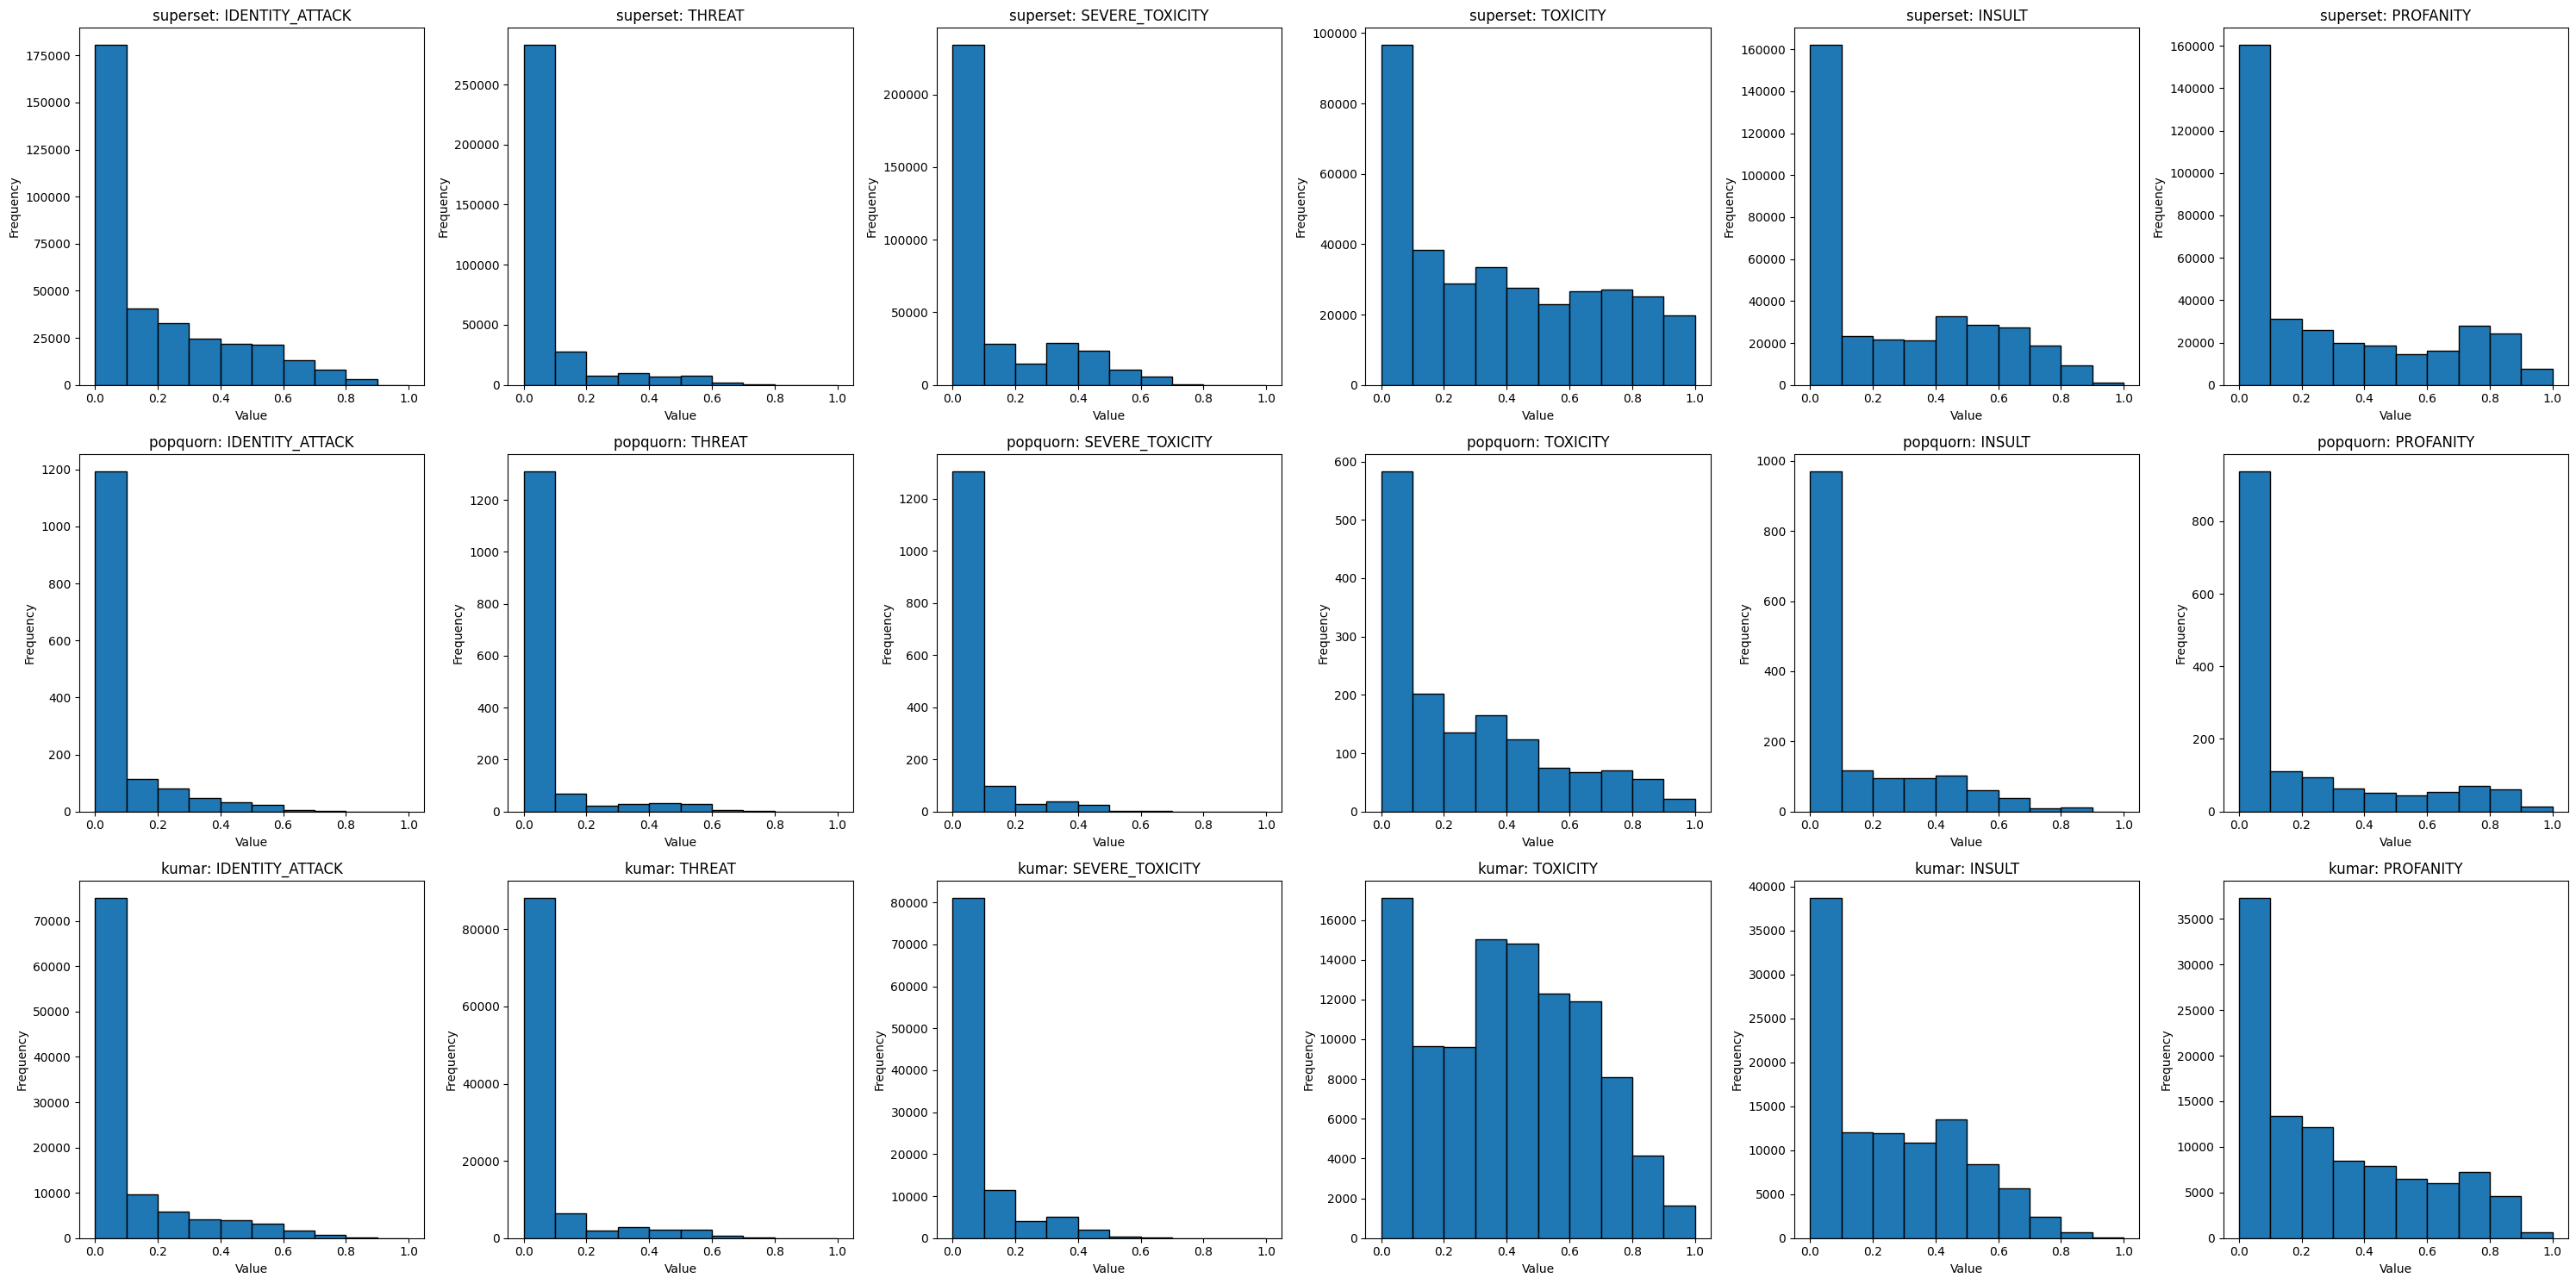

In [48]:
import matplotlib.pyplot as plt
import numpy as np


def plot_histograms_for_dict_of_dfs(dict_of_dfs):
    # Number of columns (toxicity-related features)
    columns = ['IDENTITY_ATTACK', 'THREAT', 'SEVERE_TOXICITY', 'TOXICITY', 'INSULT', 'PROFANITY']
    
    # Number of dataframes
    num_dfs = len(dict_of_dfs)
    
    # Create figure with subplots: each row corresponds to one dataframe, each column is a histogram of a feature
    fig, axes = plt.subplots(num_dfs, len(columns), figsize=(len(columns) * 5, num_dfs * 5))

    # Ensure axes is 2D even for single dataframe
    if num_dfs == 1:
        axes = np.array([axes])
    
    # Iterate over each dataframe
    for i, (df_name, df) in enumerate(dict_of_dfs.items()):
        # Iterate over each feature/column in the dataframe
        for j, col in enumerate(columns):
            ax = axes[i, j]
            ax.hist(df[col], bins=np.linspace(0, 1, 11), edgecolor='black')
            ax.set_title(f'{df_name}: {col}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example call to the function
plot_histograms_for_dict_of_dfs(df_dict)


In [49]:
# sample very TOXIC instances

THRESHOLD = 0.9

sample_dict = {}

for key in df_dict.keys():

    # write to sample_dict the instances where 'TOXICITY' has a value > THRESHOLD
    sample_dict[key] = df_dict[key][(df_dict[key]['TOXICITY'] > THRESHOLD)]
    print(f'{key}:\t {sample_dict[key].shape[0]} instances with TOXICITY > {THRESHOLD}')

# save sample_dict

for key in sample_dict.keys():
    sample_dict[key].to_csv(f'data/samples/{key}_toxic.csv', index=False)

superset:	 19657 instances with TOXICITY > 0.9
popquorn:	 22 instances with TOXICITY > 0.9
kumar:	 1636 instances with TOXICITY > 0.9


In [50]:
THRESHOLD = 0.8

sample_dict = {}

for key in df_dict.keys():

    # write to sample_dict the instances where 'IDENTITY_ATTACK', 'THREAT', or 'SEVERE_TOXICITY' has a value > THRESHOLD
    sample_dict[key] = df_dict[key][(df_dict[key]['IDENTITY_ATTACK'] > THRESHOLD) | (df_dict[key]['THREAT'] > THRESHOLD) | (df_dict[key]['SEVERE_TOXICITY'] > THRESHOLD)]
    print(f'{key}:\t {sample_dict[key].shape[0]} instances with IDENTITY_ATTACK, THREAT, or SEVERE_TOXICITY > {THRESHOLD}')

# save sample_dict

for key in sample_dict.keys():
    sample_dict[key].to_csv(f'data/samples/{key}_hate.csv', index=False)

superset:	 3133 instances with IDENTITY_ATTACK, THREAT, or SEVERE_TOXICITY > 0.8
popquorn:	 0 instances with IDENTITY_ATTACK, THREAT, or SEVERE_TOXICITY > 0.8
kumar:	 112 instances with IDENTITY_ATTACK, THREAT, or SEVERE_TOXICITY > 0.8


In [51]:
THRESHOLD = 0.7

sample_dict = {}

for key in df_dict.keys():

    # write to sample_dict the instances where 'THREAT' has a value > THRESHOLD
    sample_dict[key] = df_dict[key][(df_dict[key]['THREAT'] > THRESHOLD)]
    print(f'{key}:\t {sample_dict[key].shape[0]} instances with THREAT > {THRESHOLD}')

# save sample_dict

for key in sample_dict.keys():
    sample_dict[key].to_csv(f'data/samples/{key}_high_threat.csv', index=False)

superset:	 977 instances with THREAT > 0.7
popquorn:	 2 instances with THREAT > 0.7
kumar:	 144 instances with THREAT > 0.7
